In [7]:
import os, sys
sys.path.insert(1,'C:/Drive F/Astrophysics/stella-tutorial/')
import stella
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [69]:
plt.rcParams['font.size']=14

In [9]:
MODEL_DIR = 'C:/Drive F/Astrophysics/stella-tutorial/models/run01'
MODELS = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')]
print(MODELS)

['C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0004_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0005_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0018_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0028_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0029_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0038_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0050_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0077_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0078_i0350_b0.73.h5', 'C:/Drive F/Astrophysics/stella-tutorial/models/run01\\ensemble_s0080_i0350_b0.73.h5']


In [11]:
OUT_DIR='C:/Drive F/Astrophysics/stella-tutorial/results/'

In [13]:
cnn=stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


In [16]:
from lightkurve.search import search_lightcurvefile

In [17]:
lc=search_lightcurvefile(target='tic62124646', mission='TESS')

c:\python36\lib\site-packages\lightkurve\search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


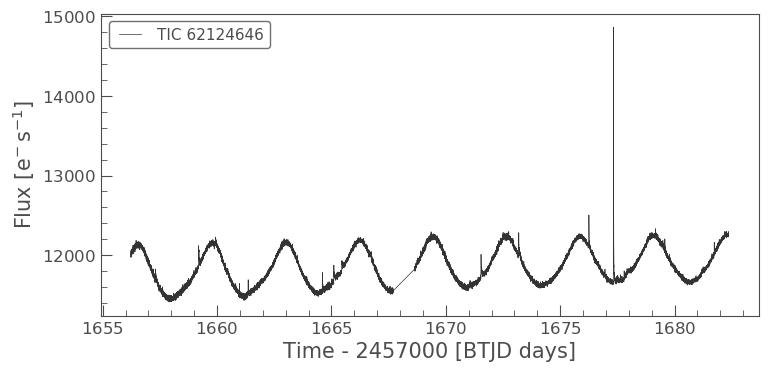

In [18]:
lc = lc.download().PDCSAP_FLUX
lc.plot()

In [20]:
cnn.predict(modelname=MODELS[0],
           times=lc.time,
           fluxes=lc.flux,
           errs=lc.flux_err)
single_pred=cnn.predictions[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


In [22]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

Text(0.5, 1.0, 'TIC 62124646')

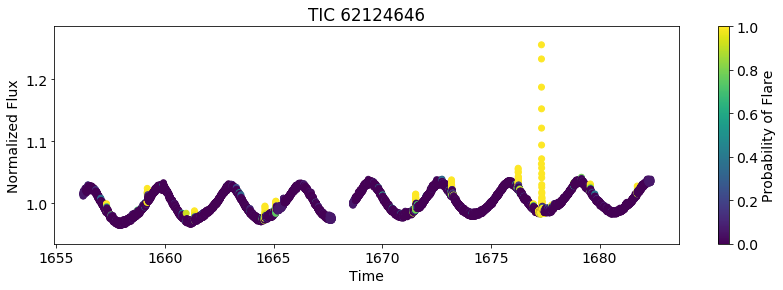

In [74]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
           c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid))

In [75]:
preds=np.zeros((len(MODELS), len(cnn.predictions[0])))

In [76]:
for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time,
                fluxes=lc.flux,
                errs=lc.flux_err)
    preds[i] = cnn.predictions[0]
    
avg_pred=np.nanmedian(preds, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


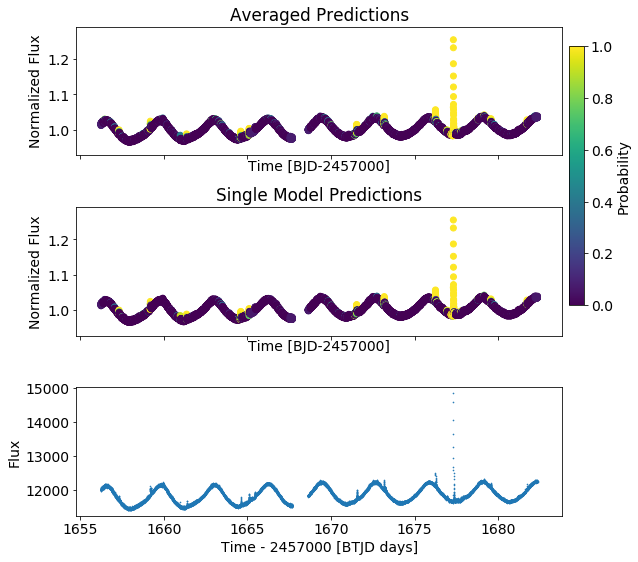

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,9), nrows=3,
                               sharex=True, sharey=False)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax1.set_xlabel('Time [BJD-2457000]')
ax1.set_ylabel('Normalized Flux')

ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux')

ax3.scatter(lc.time, lc.flux, s=0.4)

ax3.set_xlabel('Time - 2457000 [BTJD days]')
ax3.set_ylabel('Flux')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.45, 0.02, 0.4])

fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

Text(0, 0.5, 'Probability of Flares')

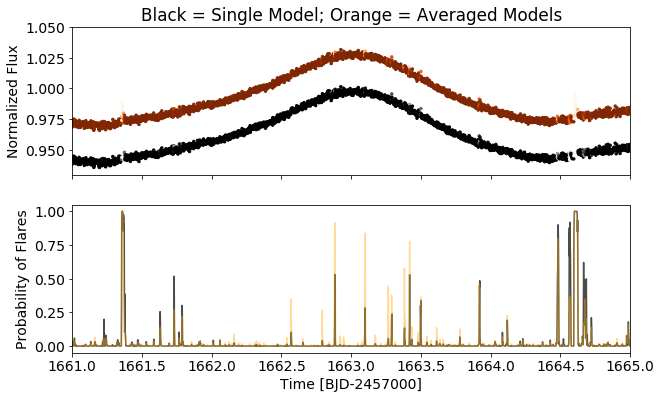

In [78]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'black', alpha=0.7)
ax2.plot(cnn.predict_time[0], avg_pred, 'orange', alpha=0.4)
ax1.set_title('Black = Single Model; Orange = Averaged Models')

plt.xlim(1661,1665)
ax2.set_xlabel('Time [BJD-2457000]')
ax1.set_ylabel('Normalized Flux')
ax2.set_ylabel('Probability of Flares')